In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import snpytools as snpy
def q(sql):
    return snpy.df_from_presto(sql, user_name = 'devon.bancroft')
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn.linear_model import Ridge, Lasso
rreg = Ridge()
lasso = Lasso()
from sklearn.model_selection import cross_val_score
from scipy.stats import probplot
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

Second model = https://jupyter.smartnews.be/user/sn/notebooks/push-notification/2020-01-02-DEVON-PUSH-new_user_activation_project-PART-2.ipynb

### Basically gave up, and created a model I was confident would work - based on user actions (e.g. pageviews, timespent, etc.)

New model=
1) Try to predict retention by user *actions*
2)D0 to D6: sent count, open_push_count, pvs, channel views, CTR, timespent

In [2]:
df = q('''SELECT
   a.user_id,
   a.install_dt,
   a.network_name,
   a.platform,
   a.day,
   a.dt,
   COALESCE(b.sent_count, 0) as sent_count,
   COALESCE(action.received_push, 0) as open_push_count,
   COALESCE(action.page_view, 0) as page_view,
   COALESCE(action.scroll, 0) as scrolls,
   COALESCE(action.impressions, 0) as impressions,
   COALESCE(timespent.timespent, 0) as timespent,
   (
   CASE
      WHEN
         c.user_id IS NULL
      THEN
         0
      ELSE
         1
   END
) as active_day
FROM
   (
      SELECT
         user_id,
         install_dt,
         platform,
         network_name,
         dt,
         date_diff('day', date_parse(install_dt, '%Y-%m-%d'), date_parse(dt, '%Y-%m-%d')) as day
      FROM
         (
            SELECT
               user_id,
               date_format(from_unixtime(creation_timestamp), '%Y-%m-%d') as install_dt,
               network_name,
               platform
            from
               daily_user_installs
            where
               dt BETWEEN '2019-10-01' AND '2019-10-31'
               AND country = 'US'
               AND mod(user_id, 10) = 5
               AND language = 'en'
               AND user_id IN
               (
                  SELECT
                     id
                  from
                     users
                  where
                     dt = '2019-12-07'
                     and j(profile, '$.pushNotificationPermission') = '1'
               )
         )
         a
         CROSS JOIN
            (
               SELECT
                  date as dt
               from
                  analytics.dates
               WHERE
                  date between '2019-10-01' AND '2019-11-07'
            )
            b
      where
         date_diff('day', date_parse(install_dt, '%Y-%m-%d'), date_parse(dt, '%Y-%m-%d')) between 0 and 7
   )
   a
   LEFT JOIN
      (
         SELECT
            user_id,
            dt,
            count(distinct push_id) as sent_count
         from
            smartnews.push_episodes
         WHERE
            dt between '2019-10-01' AND '2019-11-07'
            AND edition = 'en_US'
            AND mod(user_id, 10) = 5
         GROUP BY
            1, 2
      )
      b
      on b.user_id = a.user_id
      AND b.dt = a.dt
LEFT JOIN
         (
            SELECT
               user_id,
               dt,
               count_if(action = 'receivePush') as received_push,
               count_if(action = 'openArticle') as page_view,
               sum(cardinality(link_ids)) as impressions,
               count_if(action = 'openChannel' and channel <> 'cr_en_us_top') as scroll
            from
               actions
            WHERE
               dt between '2019-10-01' AND '2019-11-07'
               AND edition = 'en_US'
               AND mod(user_id, 10) = 5
               AND action in ('receivePush','openArticle', 'reportImpressions', 'openChannel')
            GROUP BY
               1, 2
         )
         action
         on action.user_id = a.user_id
         AND action.dt = a.dt
   LEFT JOIN
      (
         SELECT DISTINCT
            dt,
            user_id
         from
            user_activities
         where
            dt between '2019-10-01' AND '2019-11-07'
            and edition = 'en_US'
      )  
      c
      on a.user_id = c.user_id
      and c.dt = a.dt
LEFT join
      (SELECT dt, user_id, sum(session_end_timestamp-session_start_timestamp) as timespent
      from user_time_spent
      where dt between '2019-10-01' AND '2019-11-07'
      GROUP BY 1, 2
    ) timespent on a.user_id = timespent.user_id and a.dt = timespent.dt
''')

SELECT a.user_id,
       a.install_dt,
       a.network_name,
       a.platform,
       a.day,
       a.dt,
       COALESCE(b.sent_count, 0) AS sent_count,
       COALESCE(action.received_push, 0) AS open_push_count,
       COALESCE(action.page_view, 0) AS page_view,
       COALESCE(action.scroll, 0) AS scrolls,
       COALESCE(action.impressions, 0) AS impressions,
       COALESCE(timespent.timespent, 0) AS timespent,
       (CASE
            WHEN c.user_id IS NULL THEN 0
            ELSE 1
        END) AS active_day
FROM
  (SELECT user_id,
          install_dt,
          platform,
          network_name,
          dt,
          date_diff('day', date_parse(install_dt, '%Y-%m-%d'), date_parse(dt, '%Y-%m-%d')) AS DAY
   FROM
     (SELECT user_id,
             date_format(from_unixtime(creation_timestamp), '%Y-%m-%d') AS install_dt,
             network_name,
             platform
      FROM daily_user_installs
      WHERE dt BETWEEN '2019-10-01' AND '2019-10-31'
        AND country = 'U

In [3]:
df.head()

,user_id,install_dt,network_name,platform,day,dt,sent_count,open_push_count,page_view,scrolls,impressions,timespent,active_day
0,106637105,2019-10-15,Organic,android,0,2019-10-15,6,1,0,0,29,52,1
1,106637105,2019-10-15,Organic,android,1,2019-10-16,7,0,0,0,0,0,0
2,106637105,2019-10-15,Organic,android,2,2019-10-17,12,0,0,0,0,0,0
3,106637105,2019-10-15,Organic,android,3,2019-10-18,5,0,0,0,0,0,0
4,106637105,2019-10-15,Organic,android,4,2019-10-19,6,0,0,0,0,0,0


In [6]:
df.isnull().sum()

user_id            0
install_dt         0
network_name       0
platform           0
day                0
dt                 0
sent_count         0
open_push_count    0
page_view          0
scrolls            0
impressions        0
timespent          0
active_day         0
dtype: int64

### Data analysis

Text(0.5, 1.0, 'Distribution of total push opens for users who were sent at least 1 push')

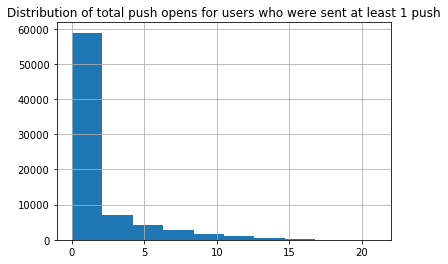

In [22]:
df[(df.open_push_count < df.open_push_count.quantile(.99))&(df.sent_count > 0)].groupby('user_id').open_push_count.sum().hist();
plt.title('Distribution of total push opens for users who were sent at least 1 push')

In [21]:
df[(df.open_push_count < df.open_push_count.quantile(.95))&(df.sent_count > 0)].groupby('user_id').open_push_count.sum().mean()

0.6832515305045387

### Most people open no pushes

Text(0.5, 1.0, 'Distribution of total page opens')

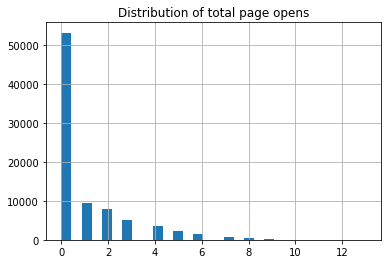

In [31]:
df[(df.page_view < df.page_view.quantile(.95))].groupby('user_id').page_view.sum().hist(bins=30);
plt.title('Distribution of total page opens')

Text(0.5, 1.0, 'Distribution of total page opens')

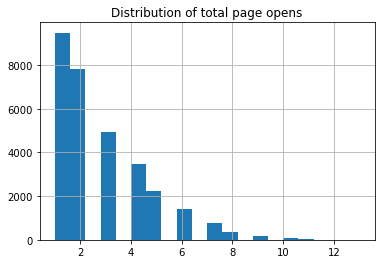

In [32]:
df[(df.page_view < df.page_view.quantile(.95))&(df.page_view > 0)].groupby('user_id').page_view.sum().hist(bins=20);
plt.title('Distribution of total page opens')

### Standard right skewed distribution

Text(0.5, 1.0, 'Distribution of total channel scrolls')

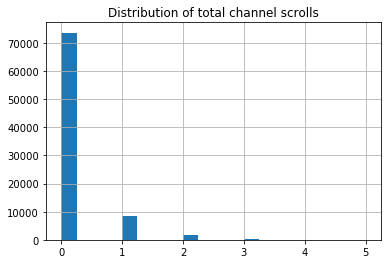

In [35]:
df[(df.scrolls < df.scrolls.quantile(.95))].groupby('user_id').scrolls.sum().hist(bins=20);
plt.title('Distribution of total channel scrolls')

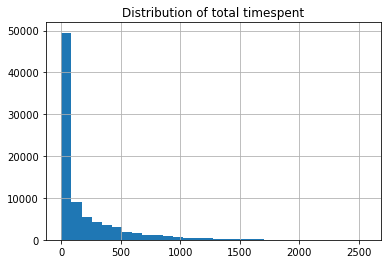

In [38]:
df[(df.timespent < df.timespent.quantile(.95))].groupby('user_id').timespent.sum().hist(bins=30);
plt.title('Distribution of total timespent');

### 50% of users spent less than 60 total seconds using the app

In [42]:
np.mean(df.groupby('user_id').timespent.sum() < 60)a

0.47759618577731394

In [ ]:
np.where(df.sent_count > df.sent_count.quantile(0.95), df.sent_count.quantile(0.95), df.sent_count)

In [78]:
df.groupby('user_id').timespent.sum().sort_values(ascending=False)

user_id
105803035    205590
104753255    119375
107462385     89884
104999245     85116
107556955     81074
              ...  
105791695         0
105789655         0
108953955         0
105789285         0
104628555         0
Name: timespent, Length: 84316, dtype: int64

In [102]:
df[df.day==7].active_day.mean()

0.15977987570567864

### 16% D7RR

## Creating a model

In [43]:
df.head()

,user_id,install_dt,network_name,platform,day,dt,sent_count,open_push_count,page_view,scrolls,impressions,timespent,active_day
0,106637105,2019-10-15,Organic,android,0,2019-10-15,6,1,0,0,29,52,1
1,106637105,2019-10-15,Organic,android,1,2019-10-16,7,0,0,0,0,0,0
2,106637105,2019-10-15,Organic,android,2,2019-10-17,12,0,0,0,0,0,0
3,106637105,2019-10-15,Organic,android,3,2019-10-18,5,0,0,0,0,0,0
4,106637105,2019-10-15,Organic,android,4,2019-10-19,6,0,0,0,0,0,0


In [50]:
df.pivot(index='user_id', columns='day', values=['sent_count', 'open_push_count', 'page_view', 'scrolls','impressions', 'timespent'])

sent_count                                          open_push_count  \
day                0     1    2     3     4     5     6     7               0   
user_id                                                                         
104628555        9.0  10.0  7.0  11.0   4.0   6.0   8.0  10.0             0.0   
104628565        9.0  10.0  7.0  10.0   4.0   6.0   8.0  10.0             0.0   
104628655        9.0  10.0  7.0  10.0   4.0   6.0   8.0  10.0             0.0   
104628675        9.0  10.0  7.0  11.0   4.0   6.0   8.0  10.0             0.0   
104628705        0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0             0.0   
...              ...   ...  ...   ...   ...   ...   ...   ...             ...   
109446055        0.0   6.0  7.0   6.0  10.0  10.0  14.0   9.0             0.0   
109446065        0.0   7.0  4.0   5.0   8.0   5.0  10.0   6.0             0.0   
109446145        0.0   7.0  4.0   5.0   8.0   5.0  10.0   6.0             0.0   
109446195        0.0   7.0  4.0   5.0   8.0   5.0  10.0   6.0             0.0   
109446215        0.0   6.0  4.0   5.0   9.0   0.0   0.0   0.0             0.0   

                ... impressions       timespent                               \
day          1  ...           6     7         0       1       2    3       4   
user_id         ...                                                            
104628555  0.0  ...         0.0   0.0       0.0     0.0     0.0  0.0     0.0   
104628565  0.0  ...         0.0   0.0       9.0     0.0     0.0  0.0     0.0   
104628655  0.0  ...         0.0   0.0       5.0     0.0     0.0  0.0     0.0   
104628675  0.0  ...         0.0   0.0      37.0     0.0     0.0  0.0     0.0   
104628705  0.0  ...         0.0   0.0      95.0     0.0     0.0  0.0     0.0   
...        ...  ...         ...   ...       ...     ...     ...  ...     ...   
109446055  0.0  ...       348.0  62.0     126.0  2185.0  5225.0  0.0  1709.0   
109446065  0.0  ...         0.0   0.0      15.0     0.0     0.0  0.0     0.0   
109446145  0.0  ...         0.0   0.0      34.0   385.0     0.0  0.0     0.0   
109446195  0.0  ...         0.0   0.0      45.0    76.0     0.0  0.0     0.0   
109446215  2.0  ...         0.0   0.0      37.0   190.0  1239.0  1.0    16.0   

                               
day          5       6      7  
user_id                        
104628555  0.0     0.0    0.0  
104628565  0.0     0.0    0.0  
104628655  0.0     0.0    0.0  
104628675  0.0     0.0    0.0  
104628705  0.0     0.0    0.0  
...        ...     ...    ...  
109446055  0.0  1811.0  181.0  
109446065  0.0     0.0    0.0  
109446145  0.0     0.0    0.0  
109446195  0.0     0.0    0.0  
109446215  0.0     0.0    0.0  

[84316 rows x 48 columns]

In [84]:
df_pivot = df[df.day != 7].pivot(index='user_id', columns='day', values=[
    'sent_count', 'open_push_count', 'page_view', 'scrolls','impressions',
    'timespent'])

In [85]:
df_pivot.keys()

MultiIndex([(     'sent_count', 0),
            (     'sent_count', 1),
            (     'sent_count', 2),
            (     'sent_count', 3),
            (     'sent_count', 4),
            (     'sent_count', 5),
            (     'sent_count', 6),
            ('open_push_count', 0),
            ('open_push_count', 1),
            ('open_push_count', 2),
            ('open_push_count', 3),
            ('open_push_count', 4),
            ('open_push_count', 5),
            ('open_push_count', 6),
            (      'page_view', 0),
            (      'page_view', 1),
            (      'page_view', 2),
            (      'page_view', 3),
            (      'page_view', 4),
            (      'page_view', 5),
            (      'page_view', 6),
            (        'scrolls', 0),
            (        'scrolls', 1),
            (        'scrolls', 2),
            (        'scrolls', 3),
            (        'scrolls', 4),
            (        'scrolls', 5),
            (        'scroll

In [86]:
df_pivot.columns.get_level_values(0)

Index(['sent_count', 'sent_count', 'sent_count', 'sent_count', 'sent_count',
       'sent_count', 'sent_count', 'open_push_count', 'open_push_count',
       'open_push_count', 'open_push_count', 'open_push_count',
       'open_push_count', 'open_push_count', 'page_view', 'page_view',
       'page_view', 'page_view', 'page_view', 'page_view', 'page_view',
       'scrolls', 'scrolls', 'scrolls', 'scrolls', 'scrolls', 'scrolls',
       'scrolls', 'impressions', 'impressions', 'impressions', 'impressions',
       'impressions', 'impressions', 'impressions', 'timespent', 'timespent',
       'timespent', 'timespent', 'timespent', 'timespent', 'timespent'],
      dtype='object')

In [87]:
df_pivot.keys()

MultiIndex([(     'sent_count', 0),
            (     'sent_count', 1),
            (     'sent_count', 2),
            (     'sent_count', 3),
            (     'sent_count', 4),
            (     'sent_count', 5),
            (     'sent_count', 6),
            ('open_push_count', 0),
            ('open_push_count', 1),
            ('open_push_count', 2),
            ('open_push_count', 3),
            ('open_push_count', 4),
            ('open_push_count', 5),
            ('open_push_count', 6),
            (      'page_view', 0),
            (      'page_view', 1),
            (      'page_view', 2),
            (      'page_view', 3),
            (      'page_view', 4),
            (      'page_view', 5),
            (      'page_view', 6),
            (        'scrolls', 0),
            (        'scrolls', 1),
            (        'scrolls', 2),
            (        'scrolls', 3),
            (        'scrolls', 4),
            (        'scrolls', 5),
            (        'scroll

In [88]:
df_pivot.columns = df_pivot.columns.map(lambda x: '|'.join([str(i) for i in x]))

In [89]:
df_pivot = df_pivot.reset_index()

In [90]:
df_pivot.head()

,user_id,sent_count|0,sent_count|1,sent_count|2,sent_count|3,sent_count|4,sent_count|5,sent_count|6,open_push_count|0,open_push_count|1,...,impressions|4,impressions|5,impressions|6,timespent|0,timespent|1,timespent|2,timespent|3,timespent|4,timespent|5,timespent|6
0,104628555,9.0,10.0,7.0,11.0,4.0,6.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,104628565,9.0,10.0,7.0,10.0,4.0,6.0,8.0,0.0,0.0,...,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
2,104628655,9.0,10.0,7.0,10.0,4.0,6.0,8.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
3,104628675,9.0,10.0,7.0,11.0,4.0,6.0,8.0,0.0,0.0,...,0.0,0.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0
4,104628705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
df_pivot = pd.merge(df[df.day==7][['user_id', 'active_day']], df_pivot, on='user_id', how='right' )

In [92]:
df_pivot.iloc[:,2:]

,sent_count|0,sent_count|1,sent_count|2,sent_count|3,sent_count|4,sent_count|5,sent_count|6,open_push_count|0,open_push_count|1,open_push_count|2,...,impressions|4,impressions|5,impressions|6,timespent|0,timespent|1,timespent|2,timespent|3,timespent|4,timespent|5,timespent|6
0,6.0,7.0,12.0,5.0,6.0,6.0,7.0,1.0,0.0,0.0,...,0.0,0.0,10.0,52.0,0.0,0.0,0.0,0.0,0.0,433.0
1,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,4.0,9.0,5.0,7.0,5.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,129.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,10.0,11.0,11.0,7.0,11.0,14.0,1.0,3.0,4.0,...,4.0,0.0,4.0,238.0,652.0,330.0,545.0,104.0,0.0,5.0
4,0.0,8.0,6.0,7.0,9.0,4.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84304,9.0,4.0,6.0,8.0,10.0,10.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
84305,8.0,4.0,6.0,8.0,10.0,10.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0
84306,9.0,4.0,6.0,10.0,12.0,12.0,8.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0
84307,10.0,4.0,6.0,8.0,10.0,10.0,9.0,0.0,0.0,0.0,...,13.0,0.0,0.0,0.0,0.0,4.0,380.0,135.0,0.0,0.0


In [93]:
df_pivot.head()

,user_id,active_day,sent_count|0,sent_count|1,sent_count|2,sent_count|3,sent_count|4,sent_count|5,sent_count|6,open_push_count|0,...,impressions|4,impressions|5,impressions|6,timespent|0,timespent|1,timespent|2,timespent|3,timespent|4,timespent|5,timespent|6
0,106637105,0,6.0,7.0,12.0,5.0,6.0,6.0,7.0,1.0,...,0.0,0.0,10.0,52.0,0.0,0.0,0.0,0.0,0.0,433.0
1,107758295,0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,108076235,0,3.0,4.0,9.0,5.0,7.0,5.0,9.0,0.0,...,0.0,0.0,0.0,129.0,0.0,0.0,0.0,0.0,0.0,0.0
3,107453365,1,2.0,10.0,11.0,11.0,7.0,11.0,14.0,1.0,...,4.0,0.0,4.0,238.0,652.0,330.0,545.0,104.0,0.0,5.0
4,107239725,0,0.0,8.0,6.0,7.0,9.0,4.0,7.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
X = df_pivot.iloc[:,2:]
y = df_pivot.active_day

In [74]:
df_pivot.shape

(84316, 50)

In [96]:
df_pivot.isnull().sum()

user_id               0
active_day            0
sent_count|0         54
sent_count|1         43
sent_count|2         34
sent_count|3         17
sent_count|4         11
sent_count|5          6
sent_count|6          0
open_push_count|0    54
open_push_count|1    43
open_push_count|2    34
open_push_count|3    17
open_push_count|4    11
open_push_count|5     6
open_push_count|6     0
page_view|0          54
page_view|1          43
page_view|2          34
page_view|3          17
page_view|4          11
page_view|5           6
page_view|6           0
scrolls|0            54
scrolls|1            43
scrolls|2            34
scrolls|3            17
scrolls|4            11
scrolls|5             6
scrolls|6             0
impressions|0        54
impressions|1        43
impressions|2        34
impressions|3        17
impressions|4        11
impressions|5         6
impressions|6         0
timespent|0          54
timespent|1          43
timespent|2          34
timespent|3          17
timespent|4     

In [97]:
df_pivot.fillna(0, inplace=True)

In [98]:
df_pivot.isnull().sum()

user_id              0
active_day           0
sent_count|0         0
sent_count|1         0
sent_count|2         0
sent_count|3         0
sent_count|4         0
sent_count|5         0
sent_count|6         0
open_push_count|0    0
open_push_count|1    0
open_push_count|2    0
open_push_count|3    0
open_push_count|4    0
open_push_count|5    0
open_push_count|6    0
page_view|0          0
page_view|1          0
page_view|2          0
page_view|3          0
page_view|4          0
page_view|5          0
page_view|6          0
scrolls|0            0
scrolls|1            0
scrolls|2            0
scrolls|3            0
scrolls|4            0
scrolls|5            0
scrolls|6            0
impressions|0        0
impressions|1        0
impressions|2        0
impressions|3        0
impressions|4        0
impressions|5        0
impressions|6        0
timespent|0          0
timespent|1          0
timespent|2          0
timespent|3          0
timespent|4          0
timespent|5          0
timespent|6

In [100]:
X = df_pivot.iloc[:,2:]
y = df_pivot.active_day

In [106]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
feature_size = [0.2, .3, .4, .5, .6, .7, .8, .9]
cross_val_scores = []
for size in feature_size:
    rf.set_params(max_features = size)
    rf.set_params(n_estimators=40)
    rf.set_params(random_state=2019)
    scores = cross_val_score(estimator = rf, X=X, y=y, cv=10)
    cross_val_scores.append((np.mean(scores), size))
cross_val_scores

[(0.883855828236225, 0.2),
 (0.8844607246224558, 0.3),
 (0.8833221118568775, 0.4),
 (0.8833220640249684, 0.5),
 (0.882717252055586, 0.6),
 (0.8832273224240421, 0.7),
 (0.8834645365828517, 0.8),
 (0.882634128055319, 0.9)]

In [101]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.set_params(max_features = 0.2)
rf.set_params(n_estimators=40)
scores = cross_val_score(estimator = rf, X=X, y=y, cv=10)
scores

array([0.88413188, 0.87820209, 0.88566006, 0.88660894, 0.88091567,
       0.88316926, 0.88435536, 0.88434164, 0.88647687, 0.88469751])

In [105]:
scores.mean()

0.8838559267233826

In [103]:
rf.set_params(max_features = 0.2)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [104]:
importances = pd.DataFrame({
    'variable': X.columns,
    'Weight': rf.feature_importances_
})
importances.sort_values(by='Weight',ascending=False)

,variable,Weight
34,impressions|6,0.090802
35,timespent|0,0.063254
20,page_view|6,0.059146
41,timespent|6,0.052315
33,impressions|5,0.046685
19,page_view|5,0.044934
32,impressions|4,0.041831
40,timespent|5,0.039168
13,open_push_count|6,0.034705
0,sent_count|0,0.033211


### Calculating F1 Score

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [110]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

In [117]:
rf.set_params(class_weight={0:1,1:2})

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 2},
                       criterion='gini', max_depth=None, max_features=0.9,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=None, oob_score=False,
                       random_state=2019, verbose=0, warm_start=False)

In [118]:
rf.fit(trainX, trainy)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 2},
                       criterion='gini', max_depth=None, max_features=0.9,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=None, oob_score=False,
                       random_state=2019, verbose=0, warm_start=False)

In [119]:
rf_probs = rf.predict_proba(testX)
#getting just the positive predictions for lr_probs
rf_probs = rf_probs[:, 1]
yhat = rf.predict(testX)
rf_precision, rf_recall, _ = precision_recall_curve(testy, rf_probs)
rf_f1, rf_auc = f1_score(testy, yhat), auc(rf_recall, rf_precision)
print('Logistic: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))

Logistic: f1=0.566 auc=0.651


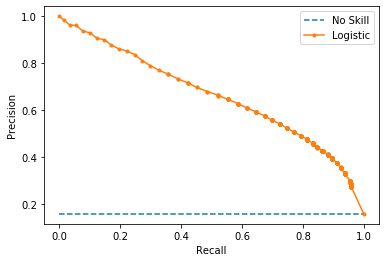

In [114]:
no_skill = len(testy[testy==1]) / len(testy)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill');
plt.plot(rf_recall, rf_precision, marker='.', label='Logistic');
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

Best result... using user behavior

Looping through different weights

In [124]:
for i in range(0,6):
    rf.set_params(class_weight={0:1,1:i})
    rf.fit(trainX, trainy)
    rf_probs = rf.predict_proba(testX)
    rf_probs = rf_probs[:, 1]
    yhat = rf.predict(testX)
    rf_precision, rf_recall, _ = precision_recall_curve(testy, rf_probs)
    rf_f1, rf_auc = f1_score(testy, yhat), auc(rf_recall, rf_precision)
    print('Weight=', i, 'Logistic: f1=%.3f auc=%.3f' % (rf_f1, rf_auc))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Weight= 0 Logistic: f1=0.000 auc=0.579
Weight= 1 Logistic: f1=0.584 auc=0.663
Weight= 2 Logistic: f1=0.566 auc=0.651
Weight= 3 Logistic: f1=0.554 auc=0.643
Weight= 4 Logistic: f1=0.548 auc=0.640
Weight= 5 Logistic: f1=0.542 auc=0.636


Summarizing: Creating a model using JUST SN push sends without any kind of user behavior does not work very well. 